In [1]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_Faulty_Training.RData')['faulty_training']

In [4]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0          0.0            1.0       1  0.25038   3674.0   4529.0   9.2320   
1          0.0            1.0       2  0.25109   3659.4   4556.6   9.4264   
2          0.0            1.0       3  0.25038   3660.3   4477.8   9.4426   
3          0.0            1.0       4  0.24977   3661.3   4512.1   9.4776   
4          0.0            1.0       5  0.29405   3679.0   4497.0   9.3381   

   xmeas_5  xmeas_6  xmeas_7  ...   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6  \
0   26.889   42.402   2704.3  ...  53.744  24.657  62.544  22.137  39.935   
1   26.721   42.576   2705.0  ...  53.414  24.588  59.259  22.084  40.176   
2   26.875   42.070   2706.2  ...  54.357  24.666  61.275  22.380  40.244   
3   26.758   42.063   2707.2  ...  53.946  24.725  59.856  22.277  40.257   
4   26.889   42.650   2705.1  ...  53.658  28.797  60.717  21.947  39.144   

    xmv_7   xmv_8   xmv_9  xmv_10  xmv_11  
0  42.323  47.757  47.510  41.258  18.447  
1  38.554  43.692  47.427  41.359  17.194  
2  38.990  46.699  47.468  41.199  20.530  
3  38.072  47.541  47.658  41.643  18.089  
4  41.955  47.645  47.346  41.507  18.461  

[5 rows x 55 columns]

# Scale the Dataset

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
fault_free = DF[DF['faultNumber']==0].iloc[:,3:]

fault_free_scaled = sc.fit_transform(fault_free)

# Preprocess dataset using Sliding window

In [2]:
def SlidingWindow(df,w,s):
    X=[]
    Y=[]
    for i in range(0,len(df)-w,s):
        x = np.array(df[i:i+w,:])
        y = np.array(df[i+w,:])
        X.append(x)
        Y.append(y)

    X=np.array(X)
    Y=np.array(Y)

    return X,Y

In [88]:
w=10
s=10

X_faultFree=[]
Y_faultFree=[]

for i in range(1,500):
    df = DF[(DF['faultNumber']==0) & (DF['simulationRun']==i)].iloc[:,3:]
    df_sc = sc.transform(df)
    
    x_temp,y_temp = SlidingWindow(df_sc,w,s)
    X_faultFree.append(x_temp)
    Y_faultFree.append(y_temp)
    
X_faultFree=np.array(X_faultFree).reshape((-1,w,52))
Y_faultFree=np.array(Y_faultFree).reshape((-1,52))

In [89]:
X_faultFree.shape

(24451, 10, 52)

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_faultFree, Y_faultFree, test_size=0.2, random_state=42)

In [91]:
X_train.shape

(19560, 10, 52)

In [92]:
y_train.shape

(19560, 52)

# Construct Neural Net

In [93]:
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def CNN_model(X_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2],1))

    # Define encoder layers
    encoded = Conv2D(64, kernel_size=(3,3), activation='relu')(input_layer)
    encoded = MaxPooling2D(pool_size=(2,2))(encoded)
    encoded = Conv2D(128, kernel_size=(3,3), activation='relu')(encoded)
    encoded = Flatten()(encoded)
    decoded = Dense(X_train.shape[2], activation='linear')(encoded)
    # Define autoencoder model
    cnn_model = Model(inputs=input_layer, outputs=decoded)
    # Compile autoencoder model
    cnn_model.compile(optimizer='adam', loss='mse')
    return cnn_model

def LSTM_model(X_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
    # Define encoder layers
    encoded = LSTM(64,activation='relu',return_sequences=True)(input_layer)
    encoded = LSTM(64,activation='relu')(encoded)
    decoded = Dense(X_train.shape[2], activation='linear')(encoded)
    # Define autoencoder model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile autoencoder model
    lstm_model.compile(optimizer='adam', loss='mse')
    return lstm_model

# Train the DeepLearning Model

Epoch 1/300
153/153 [==============================] - 12s 49ms/step - loss: 0.7786 - val_loss: 0.6694
Epoch 2/300
153/153 [==============================] - 7s 43ms/step - loss: 0.6316 - val_loss: 0.6149
Epoch 3/300
153/153 [==============================] - 6s 42ms/step - loss: 0.6052 - val_loss: 0.6020
Epoch 4/300
153/153 [==============================] - 7s 44ms/step - loss: 0.5965 - val_loss: 0.5997
Epoch 5/300
153/153 [==============================] - 7s 43ms/step - loss: 0.5920 - val_loss: 0.5948
Epoch 6/300
153/153 [==============================] - 7s 43ms/step - loss: 0.5888 - val_loss: 0.5921
Epoch 7/300
153/153 [==============================] - 7s 43ms/step - loss: 0.5869 - val_loss: 0.5911
Epoch 8/300
153/153 [==============================] - 7s 43ms/step - loss: 0.5857 - val_loss: 0.5901
Epoch 9/300
153/153 [==============================] - 6s 42ms/step - loss: 0.5839 - val_loss: 0.5900
Epoch 10/300
153/153 [==============================] - 7s 43ms/step - loss: 0.58

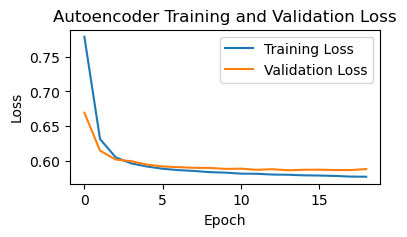

In [105]:
# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
# Crete the DeepLearning Model
DLmodel=LSTM_model(X_train)
# Fit autoencoder model with early stopping callback
history = DLmodel.fit(X_train, y_train,
                epochs=300,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping_callback])

plt.rcParams['figure.figsize'] = [4, 2]
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize the Reconstructed Data 

In [107]:
temp = DF[(DF['faultNumber']==0) & (DF['simulationRun'] == np.random.randint(1,500) )] #Normal state
# Scale the data to standardize
temp_sc = sc.transform(temp.iloc[:,3:])

x,y = SlidingWindow(temp_sc,w,s=1)

y_pred = DLmodel.predict(x,verbose = 0)

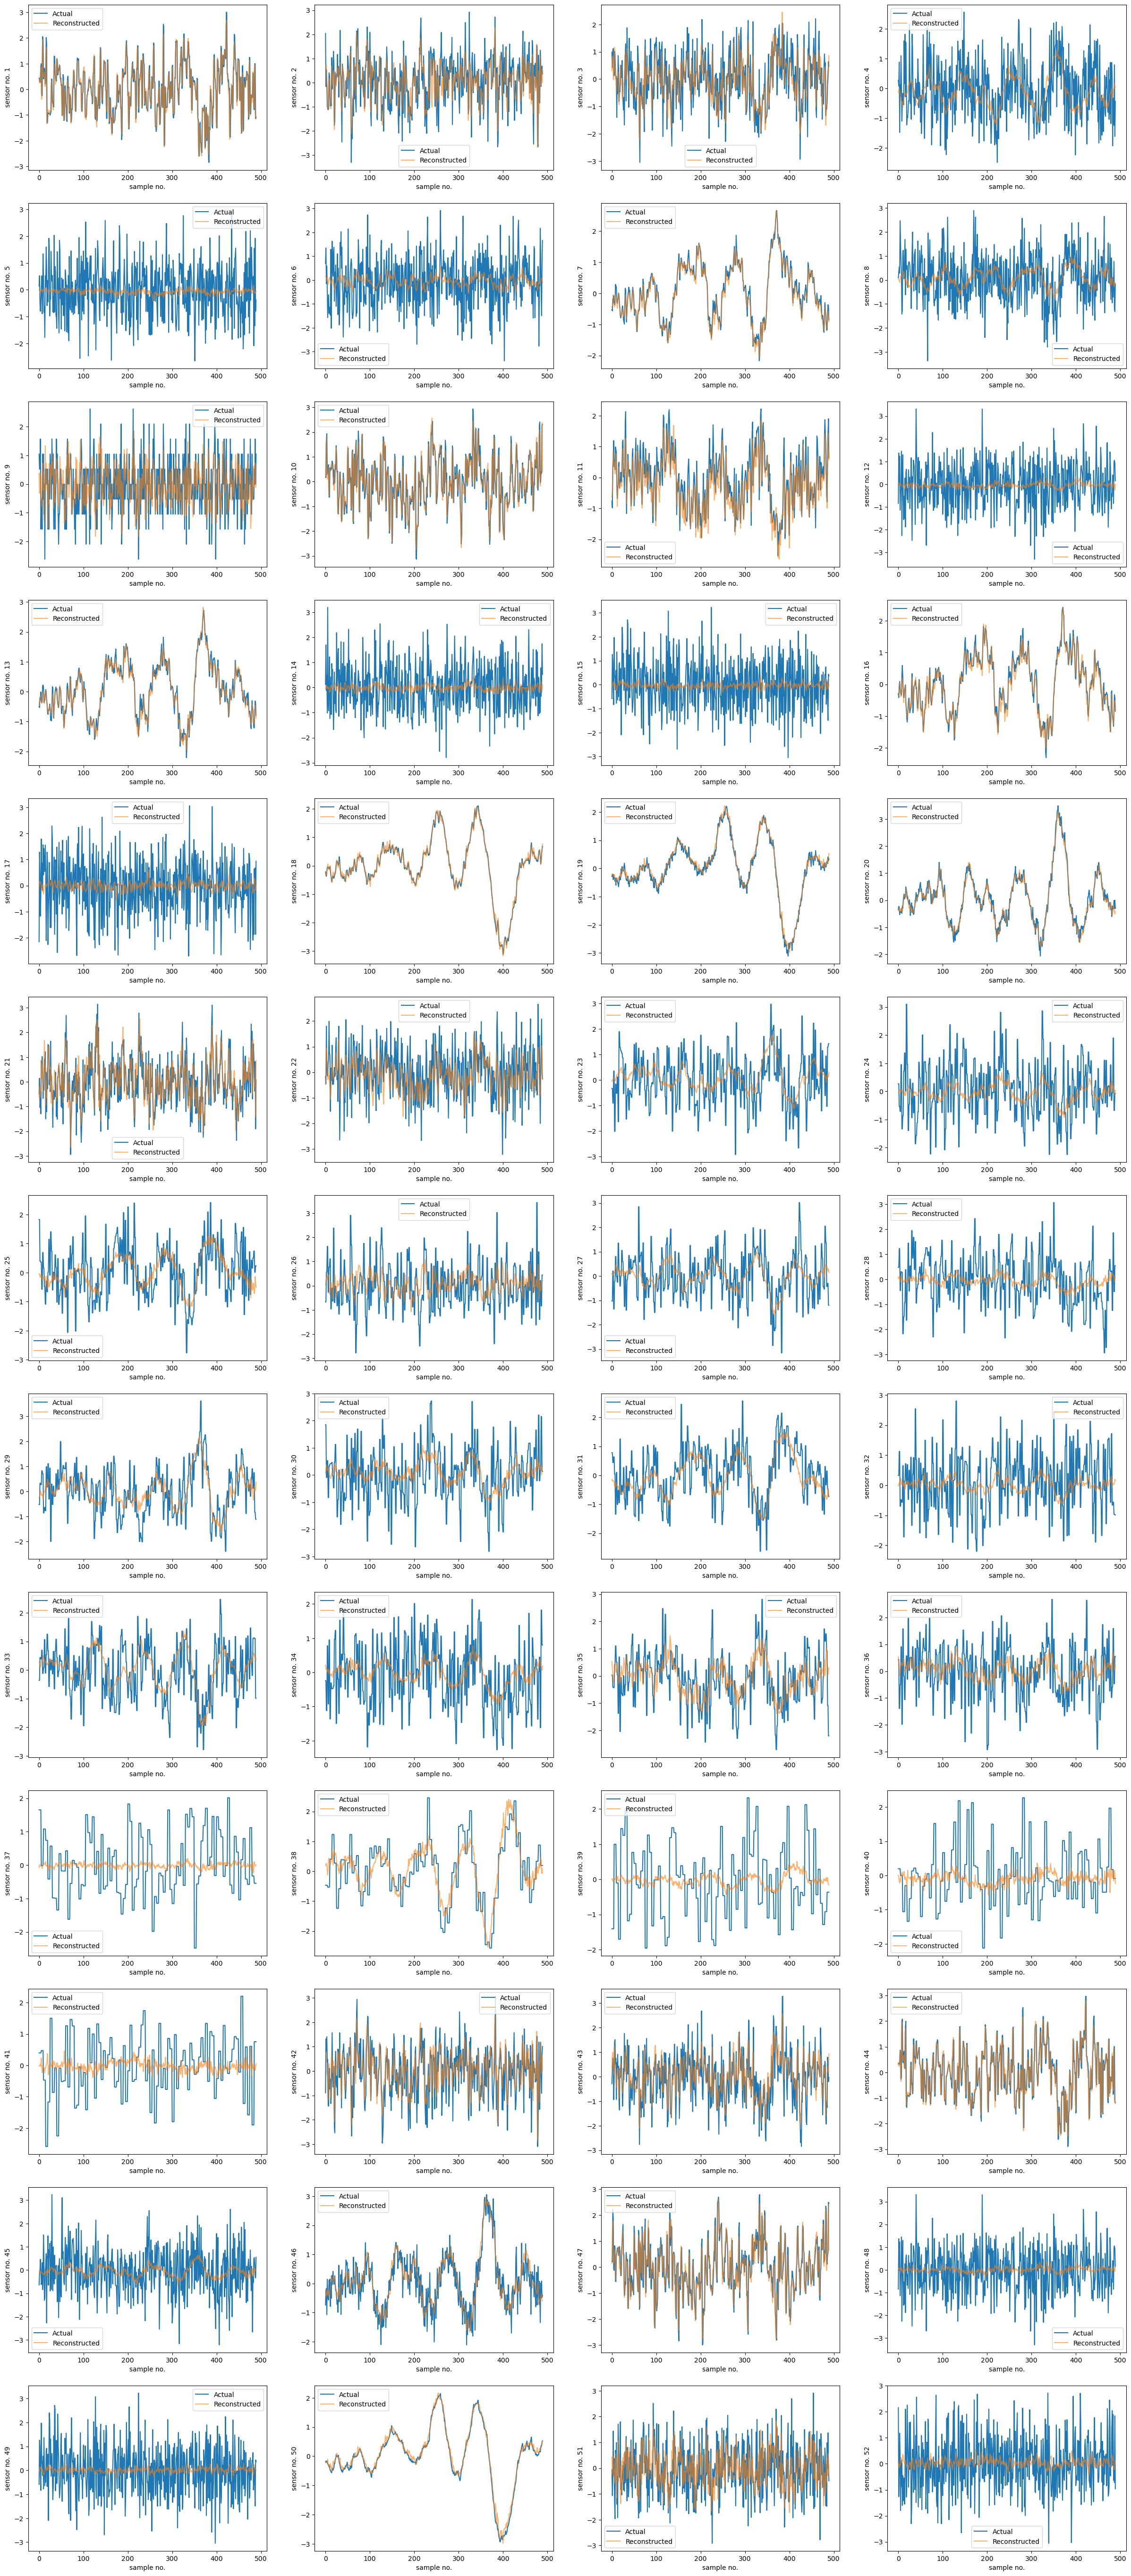

In [108]:
fig, ax = plt.subplots(13,4,figsize=(30,70))

for i in range (0,y_pred.shape[1]):  #select all the feature columns to plot
    ax.ravel()[i].plot(y[:,i],label='Actual')
    ax.ravel()[i].plot(y_pred[:,i],label='Reconstructed',alpha=0.6)
    ax.ravel()[i].set_xlabel('sample no.')
    ax.ravel()[i].set_ylabel(f'sensor no. {i+1}')
    ax.ravel()[i].legend()
   
  

In [97]:
def recon_loss(NN,X,y):
    #NN is the trained neural network model
    y_pred = NN.predict(X,verbose = 0)
    reconstruction_loss = np.mean((y-y_pred)**2,axis=1)
    return reconstruction_loss

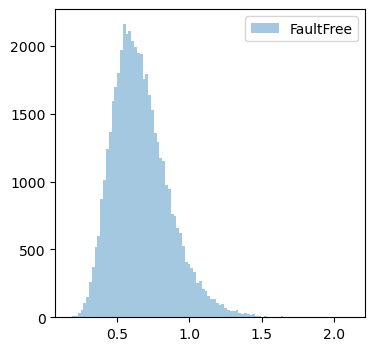

In [109]:
FaultFree_reconstruction_loss=[]

for i in range(1,100):
    df = DF[(DF['faultNumber']==0) & (DF['simulationRun']==i)].iloc[:,3:]
    df_sc = sc.transform(df)
    
    x_temp,y_temp = SlidingWindow(df_sc,w=w,s=1)
    
    FaultFree_reconstruction_loss.append(recon_loss(DLmodel,x_temp,y_temp))
    
    
FaultFree_reconstruction_loss=np.array(FaultFree_reconstruction_loss).reshape(-1,1)

plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(FaultFree_reconstruction_loss, bins=100,label='FaultFree',alpha=0.4)
plt.legend()
plt.show()

In [99]:
FaultFree_reconstruction_loss.shape

(48510, 1)

# Realtime Fault detection

In [110]:
# Obtain mean and standard deviation for 
mu = np.mean(FaultFree_reconstruction_loss)
std = np.std(FaultFree_reconstruction_loss)

# Obtain threshold from mu and std
threshold = mu+3*std
threshold

1.25935056144277

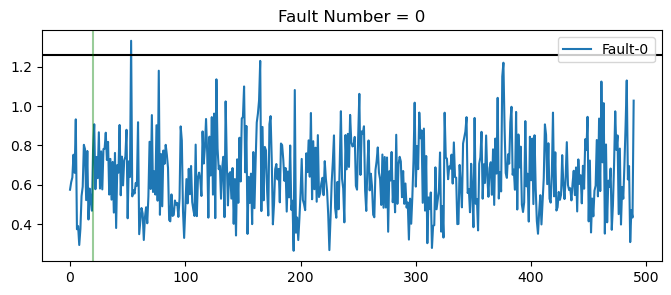

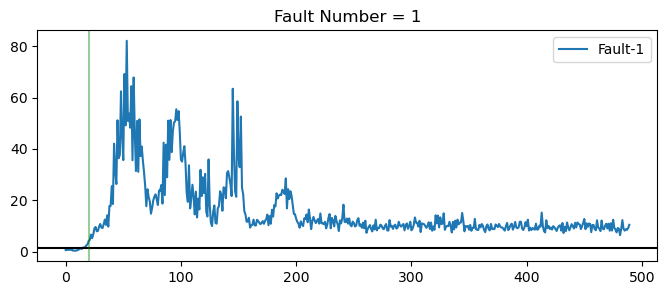

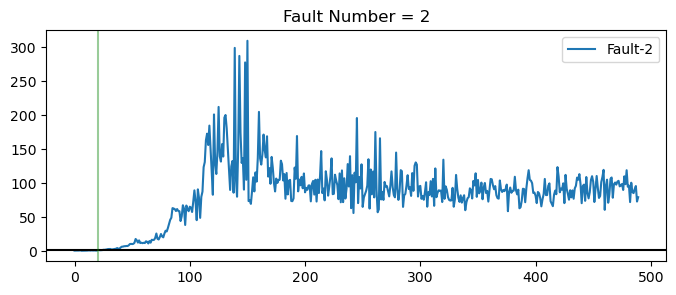

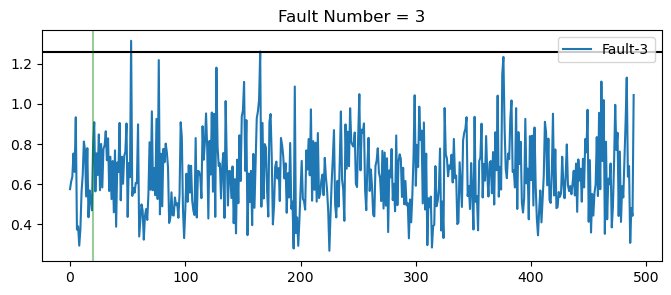

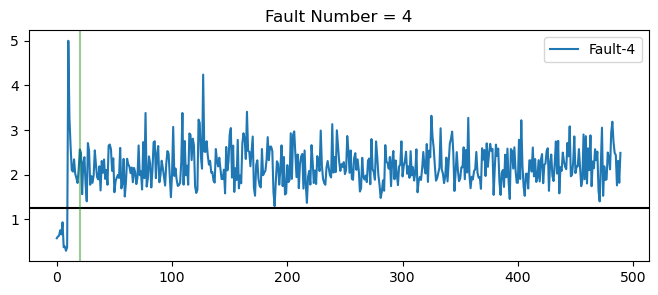

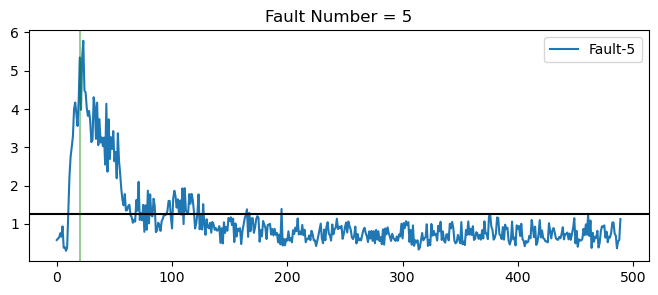

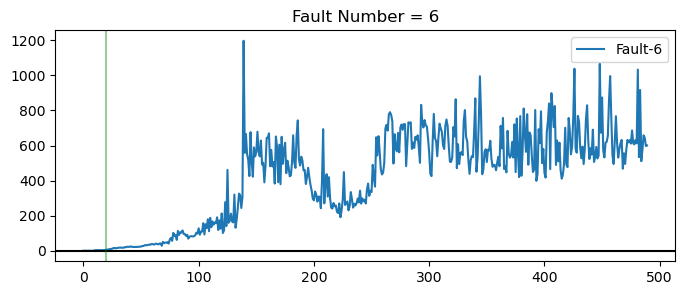

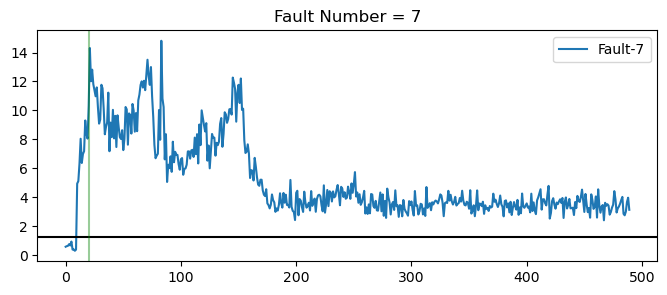

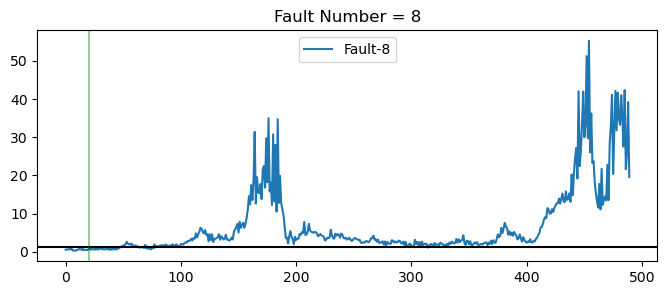

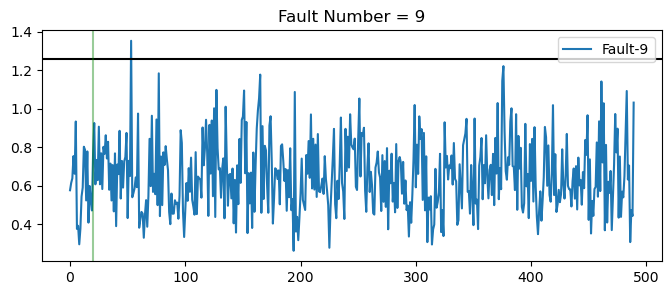

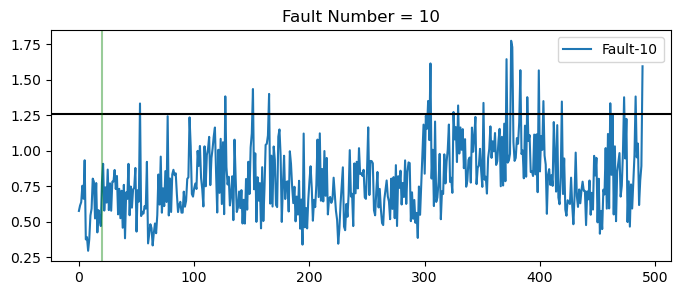

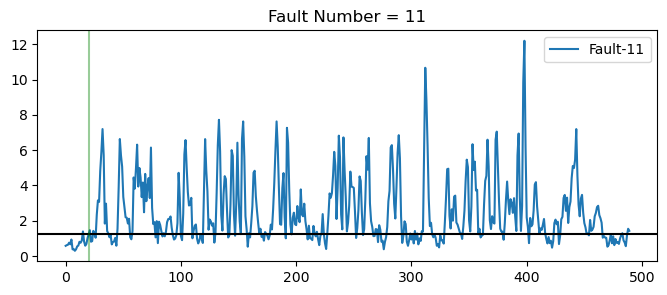

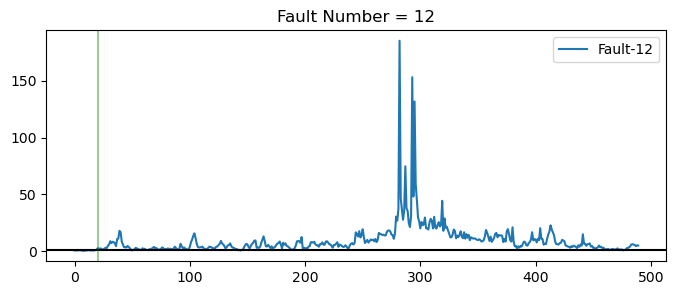

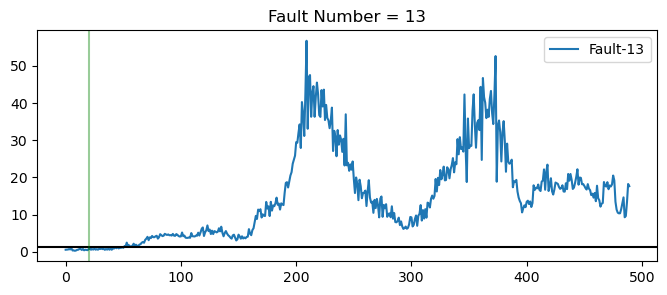

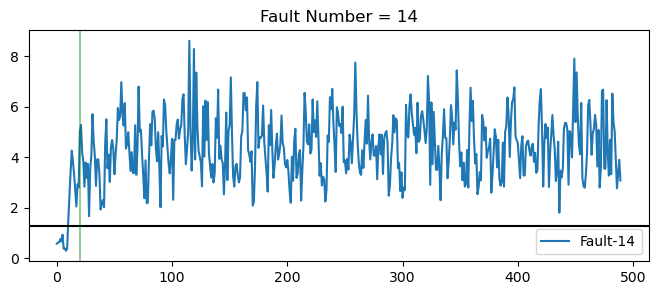

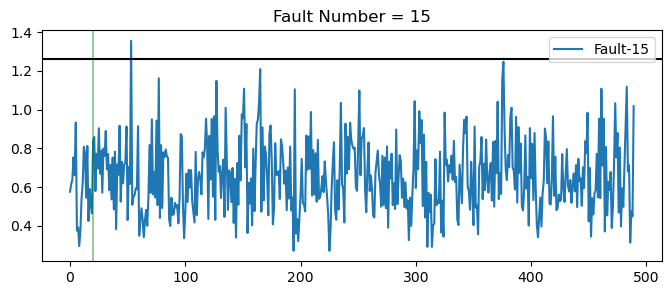

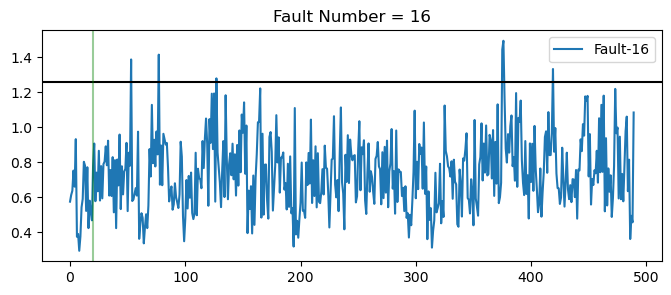

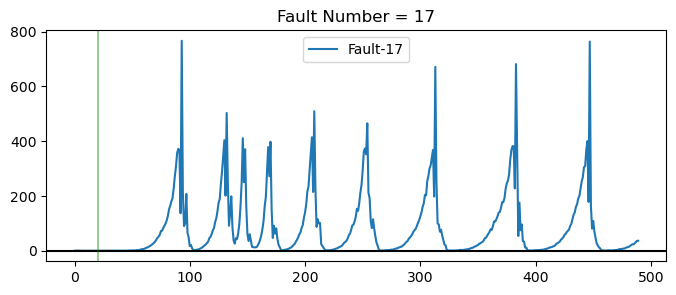

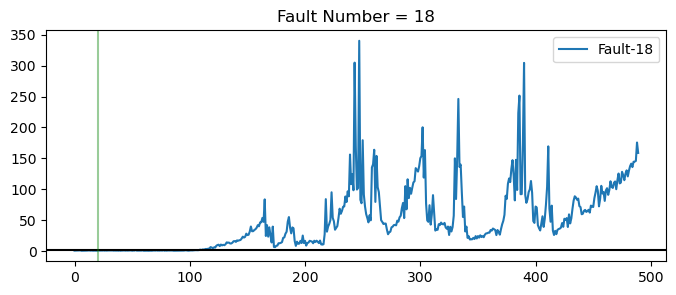

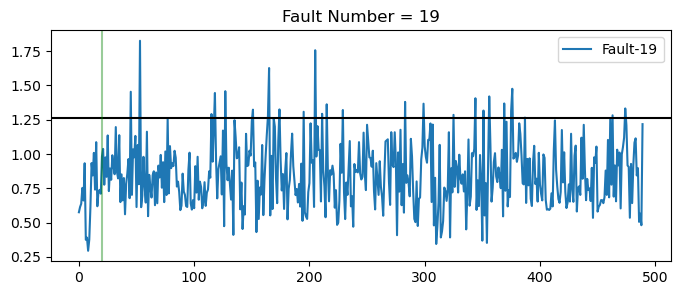

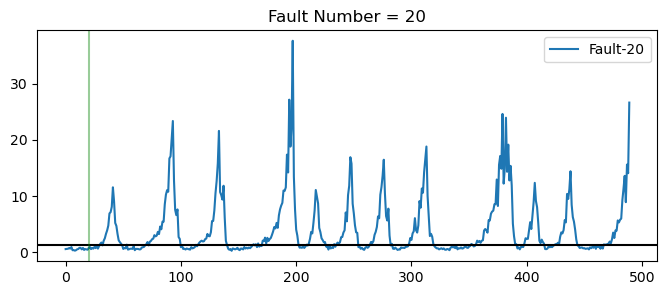

In [111]:

for F_num in range(0,21):
    # store the required fault class and simulation run
    temp = DF[(DF.faultNumber==F_num) & (DF.simulationRun==1 )]  #Faulty Condition
    # Standardization
    X_faulty = sc.transform(temp.iloc[:,3:])
    
    x_temp,y_temp = SlidingWindow(X_faulty,w=w,s=1)
    # Obtain reconstruction loss
    faulty_reconstruction_loss = recon_loss(NN=DLmodel,X=x_temp,y=y_temp) 

    plt.rcParams['figure.figsize'] = [8,3]
    plt.plot(faulty_reconstruction_loss,label=f'Fault-{F_num}')
    plt.axhline(threshold,c='k')    #threshold value
    plt.axvline(20,c='g',alpha=0.4) #time of fault introduction
    plt.title(f'Fault Number = {F_num}')
    plt.legend()
    plt.show()

    

# Evaluate F1 score to compare performance

In [112]:
def combine_result(x,threshold):
    # IF reconstruction loss is grater than threshold THEN its a fault
    result= x > threshold
    result_float = [float(val) for val in result] 
    return result_float

In [103]:
for Fnum in [x for x in range(0,21) if x not in [3,9]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['simulationRun']==1) ]
    X_faulty = sc.transform(temp_df.iloc[:,3:])
    
    x_temp,y_temp = SlidingWindow(X_faulty,w=w,s=1)
    # Obtain reconstruction loss
    faulty_reconstruction_loss = recon_loss(NN=DLmodel,X=x_temp,y=y_temp) 
    
    #populate the true value (y_true) based of Fnum
    y_pred = combine_result(x=faulty_reconstruction_loss,threshold=threshold)
    
    
    if Fnum==0:
        y_true = np.repeat(0, len(y_pred))
    else:
        y_true = np.repeat(1, len(y_pred))
        y_true[0:21]=0 # Beacuse the fault was introduced after 20th sample
        

    # Obtain F1 score    
    from sklearn.metrics import f1_score,accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print(f'The F1-Score for Fault_num={Fnum} is {f1}')
    print(f'The Accuracy-Score for Fault_num={Fnum} is {acc}')
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm=confusion_matrix(y_true, y_pred)
    print(cm)

The F1-Score for Fault_num=0 is 0.49948927477017363
The Accuracy-Score for Fault_num=0 is 0.9979591836734694
[[489   1]
 [  0   0]]
The F1-Score for Fault_num=1 is 0.9134887005649717
The Accuracy-Score for Fault_num=1 is 0.9877551020408163
[[ 15   6]
 [  0 469]]
The F1-Score for Fault_num=2 is 0.9762043512043511
The Accuracy-Score for Fault_num=2 is 0.9959183673469387
[[ 21   0]
 [  2 467]]
The F1-Score for Fault_num=4 is 0.7777777777777777
The Accuracy-Score for Fault_num=4 is 0.9693877551020408
[[ 10  11]
 [  4 465]]
The F1-Score for Fault_num=5 is 0.12700013446282102
The Accuracy-Score for Fault_num=5 is 0.1346938775510204
[[ 10  11]
 [413  56]]
The F1-Score for Fault_num=6 is 0.8167850708725654
The Accuracy-Score for Fault_num=6 is 0.9775510204081632
[[ 10  11]
 [  0 469]]
The F1-Score for Fault_num=7 is 0.8167850708725654
The Accuracy-Score for Fault_num=7 is 0.9775510204081632
[[ 10  11]
 [  0 469]]
The F1-Score for Fault_num=8 is 0.6448949178838637
The Accuracy-Score for Fault_n

# Get the mean-F1 score of all types of faults from (0-21) for bench marking

In [113]:
F1_all = [] #initialize the emplty list of F1 score
Acc_all = []
for Fnum in [x for x in range(0,21) if x not in [3,9]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['simulationRun']==np.random.randint(1,100))]
    X_faulty = sc.transform(temp_df.iloc[:,3:])
    
    x_temp,y_temp = SlidingWindow(X_faulty,w=w,s=1)
    # Obtain reconstruction loss
    faulty_reconstruction_loss = recon_loss(NN=DLmodel,X=x_temp,y=y_temp) 

    
    y_pred = combine_result(x=faulty_reconstruction_loss,threshold=threshold)
    
    if Fnum==0:
        y_true = np.repeat(0, len(y_pred))
    else:
        y_true = np.repeat(1, len(y_pred))
        y_true[0:21]=0 # Beacuse the fault was introduced after 20th sample

    # Obtain F1 score    
    from sklearn.metrics import f1_score,accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    F1_all.append(f1)
    Acc_all.append(acc)
    
print(f'The mean F1-Score for Autoencoder-reconstruction method is {np.mean(np.array(F1_all))}')
print(f'The mean Accuracy-Score for Autoencoder-reconstruction method is {np.mean(np.array(Acc_all))}')

The mean F1-Score for Autoencoder-reconstruction method is 0.5751538387222539
The mean Accuracy-Score for Autoencoder-reconstruction method is 0.7083780880773362
